In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

from pyHSICLasso import HSICLasso
from hsic_optimization.hsic_lasso import cd_hsic_lasso

In [2]:
ncol = 200
nsample = 100
coeffs = np.array([5.0, 5.0, 5.0])

rng = np.random.default_rng(12345)

X = rng.choice(a=[0, 1, 2], p=[0.8, 0.18, 0.02], replace=True, size=(nsample, ncol - 1))
e = np.random.normal(size=(nsample,))
# the last feature is a redundant feature, which is related to X0 but have no relationship with Y.
X = np.c_[X, X[:, 0] + 0.5 * e]


# generate y
def sim_model(x1, x2, x3, x4, beta1, beta2, beta3):
    e = np.random.normal(size=x1.shape)
    return beta1 * x1 + beta2 * np.cos(x2) + beta3 * x3 * np.sin(x4) + e


y = sim_model(X[:, 0], X[:, 1], X[:, 2], X[:, 3], coeffs[0], coeffs[1], coeffs[2])

# construct binary respond
p1 = sp.expit(y - np.mean(y))
Y = rng.binomial(1, p1)

In [3]:
def plot_features(feats, scores):
    _, ax = plt.subplots(figsize=(12, 5))
    ax.plot(scores, "o")
    ax.grid(True)
    ax.set_xticks(range(len(feats)))
    ax.set_xticklabels(feats)
    ax.set_ylabel("feature score")
    ax.set_xlabel("feature index")

    return ax

In [4]:
%%time
hsic_lasso = HSICLasso()
hsic_lasso.input(X, Y)
_ = hsic_lasso.classification(num_feat=10)

Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
CPU times: user 136 ms, sys: 81.7 ms, total: 218 ms
Wall time: 2.89 s


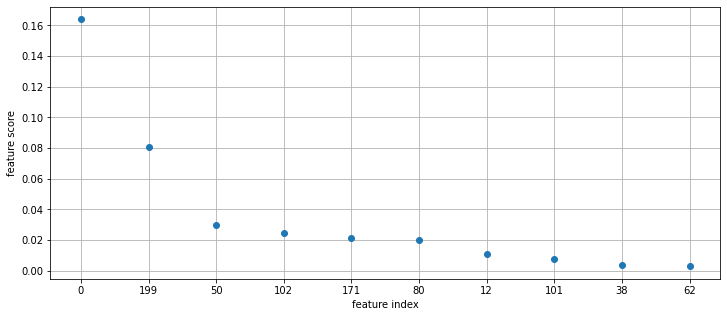

In [5]:
feats = hsic_lasso.get_index()
scores = hsic_lasso.get_index_score()
_ = plot_features(feats, scores)

The following code call coordinate-descent HSIC Lasso solver using data matrix directly.
Note the features need to be the first dimension of X, hence the transpositions.

In [6]:
path, beta, lams = cd_hsic_lasso(X.T, Y, B=20, M=3, num_feat=10)

CPU times: user 32.3 ms, sys: 395 µs, total: 32.7 ms
Wall time: 31.5 ms


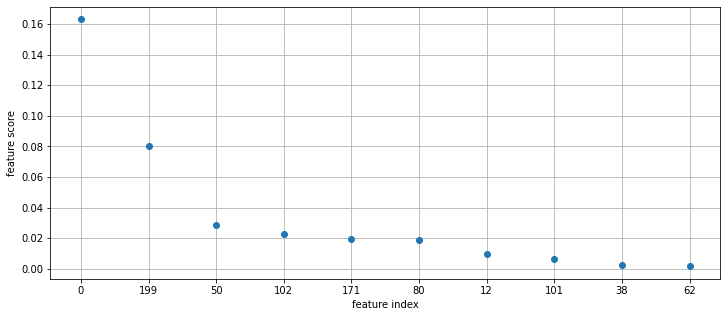

In [7]:
%%time
feats_accel = np.where(beta > 0)[0]
scores_accel = beta[feats_accel]
indices = np.argsort(scores_accel)[::-1]
_ = plot_features(feats_accel[indices], scores_accel[indices])